Potentially Hazardous Asteroids (PHAs) are currently defined based on parameters that measure the asteroid's potential to make threatening close approaches to the Earth. Specifically, all asteroids with an Earth Minimum Orbit Intersection Distance (MOID) of 0.05 au or less and an absolute magnitude (H) of 22.0 or less are considered PHAs. In other words, asteroids that can't get any closer to the Earth (i.e., MOID) than 0.05 au (roughly 7,480,000 km or 4,650,000 mi) or are smaller than about 140 m (~500 ft) in diameter (i.e., H = 22.0 with assumed albedo of 14%) are not considered PHAs.

In [76]:
import pandas as pd
from datetime import timedelta, date
import configparser
import pickle

#libraries for api get requests
import requests
from urllib.request import urlretrieve
import json

# import models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# import evaluation functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score

# scikitplot to directly plot our results
import graphviz
import scikitplot as skplt
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import category_scatter


In [2]:
# Setting Column widthsize to view all columns in pandas data frame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
config = configparser.ConfigParser()
config.read('dl.cfg')
apiKey = config['NASA']['apikey']


# **NEO FEED**

### **Sample Output**
`{'absolute_magnitude_h': 19.88,
 'close_approach_data': [{'close_approach_date': '2021-11-10',
                          'close_approach_date_full': '2021-Nov-10 20:29',
                          'epoch_date_close_approach': 1636576140000,
                          'miss_distance': {'astronomical': '0.2306734775',
                                            'kilometers': '34508260.899492925',
                                            'lunar': '89.7319827475',
                                            'miles': '21442439.023835365'},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': '46525.6340756068',
                                                'kilometers_per_second': '12.9237872432',
                                                'miles_per_hour': '28909.219684368'}}],
 'estimated_diameter': {'feet': {'estimated_diameter_max': 2060.7486784504,
                                 'estimated_diameter_min': 921.5948259116},
                        'kilometers': {'estimated_diameter_max': 0.6281161771,
                                       'estimated_diameter_min': 0.2809020939},
                        'meters': {'estimated_diameter_max': 628.116177092,
                                   'estimated_diameter_min': 280.902093949},
                        'miles': {'estimated_diameter_max': 0.3902931771,
                                  'estimated_diameter_min': 0.174544415}},
 'id': '2068347',
 'is_potentially_hazardous_asteroid': True,
 'is_sentry_object': False,
 'links': {'self': 'http://www.neowsapp.com/rest/v1/neo/2068347?api_key=xxxxxxxxxxxx'},
 'name': '68347 (2001 KB67)',
 'nasa_jpl_url': 'http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=2068347',
 'neo_reference_id': '2068347'}`

In [49]:
with open("rawdata.pickle", "rb") as f:   # Loading the data collected 
   raw = pickle.load(f)

In [50]:
df = pd.DataFrame(raw)

In [51]:
df.isnull().sum()

links                                0
id                                   0
neo_reference_id                     0
name                                 0
nasa_jpl_url                         0
absolute_magnitude_h                 1
estimated_diameter                   1
is_potentially_hazardous_asteroid    0
close_approach_data                  0
is_sentry_object                     0
dtype: int64

In [52]:
#Droping Null Values
df.dropna(inplace=True)

In [53]:
# Getting Data from nested dictionaries of certain columns

df['estimated_diameter_min_km'] = df['estimated_diameter'].apply(lambda x: x['kilometers']['estimated_diameter_min'])

df['estimated_diameter_max_km'] = df['estimated_diameter'].apply(lambda x: x['kilometers']['estimated_diameter_max'])

df['close_approach_date'] = df['close_approach_data'].apply(lambda x: x[0]['close_approach_date'])

df['miss_distance_au'] = df['close_approach_data'].apply(lambda x: x[0]['miss_distance']['astronomical'])

df['relative_velocity_kmps'] = df['close_approach_data'].apply(lambda x: x[0]['relative_velocity']['kilometers_per_second'])

df['orbiting_body'] = df['close_approach_data'].apply(lambda x: x[0]['orbiting_body'])

In [54]:
df.dtypes

links                                 object
id                                    object
neo_reference_id                      object
name                                  object
nasa_jpl_url                          object
absolute_magnitude_h                 float64
estimated_diameter                    object
is_potentially_hazardous_asteroid       bool
close_approach_data                   object
is_sentry_object                        bool
estimated_diameter_min_km            float64
estimated_diameter_max_km            float64
close_approach_date                   object
miss_distance_au                      object
relative_velocity_kmps                object
orbiting_body                         object
dtype: object

In [55]:
df.head(4)

,links,id,neo_reference_id,name,nasa_jpl_url,absolute_magnitude_h,estimated_diameter,is_potentially_hazardous_asteroid,close_approach_data,is_sentry_object,estimated_diameter_min_km,estimated_diameter_max_km,close_approach_date,miss_distance_au,relative_velocity_kmps,orbiting_body
0,{'self': 'http://www.neowsapp.com/rest/v1/neo/...,2053789,2053789,53789 (2000 ED104),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=2053789,17.33,{'kilometers': {'estimated_diameter_min': 0.90...,True,"[{'close_approach_date': '2002-10-09', 'close_...",False,0.908981,2.032544,2002-10-09,0.1657650913,21.5748905048,Earth
1,{'self': 'http://www.neowsapp.com/rest/v1/neo/...,2338292,2338292,338292 (2002 UA31),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=2338292,19.02,{'kilometers': {'estimated_diameter_min': 0.41...,False,"[{'close_approach_date': '2002-10-09', 'close_...",False,0.417402,0.933340,2002-10-09,0.2255639049,17.3257341038,Earth
2,{'self': 'http://www.neowsapp.com/rest/v1/neo/...,3251590,3251590,(2004 RC80),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3251590,24.40,{'kilometers': {'estimated_diameter_min': 0.03...,False,"[{'close_approach_date': '2002-10-09', 'close_...",False,0.035039,0.078350,2002-10-09,0.4332412059,17.0376265666,Earth
3,{'self': 'http://www.neowsapp.com/rest/v1/neo/...,3255465,3255465,(2004 SC56),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3255465,22.70,{'kilometers': {'estimated_diameter_min': 0.07...,False,"[{'close_approach_date': '2002-10-09', 'close_...",False,0.076658,0.171412,2002-10-09,0.0408540265,11.1709911789,Earth


In [56]:
#df_na4[['year','month','day']] = df_na4[['year','month','day']].apply(pd.to_numeric)
df[['id','neo_reference_id','miss_distance_au','relative_velocity_kmps',]] =df[['id','neo_reference_id','miss_distance_au','relative_velocity_kmps',]].apply(pd.to_numeric)

In [35]:
df[['close_approach_date']] = df[['close_approach_date']].apply(pd.to_datetime)
#df['miss_distance_au'] = df['miss_distance_au'].apply(lambda x: round(x,2))
#df['relative_velocity_kmps'] = df['relative_velocity_kmps'].apply((lambda x: round(x,2)))
#df['absolute_magnitude_h'] = df['absolute_magnitude_h'].apply(lambda x: round(x,2))

In [36]:
df.dtypes

links                                        object
id                                            int64
neo_reference_id                              int64
name                                         object
nasa_jpl_url                                 object
absolute_magnitude_h                        float64
estimated_diameter                           object
is_potentially_hazardous_asteroid              bool
close_approach_data                          object
is_sentry_object                               bool
estimated_diameter_min_km                   float64
estimated_diameter_max_km                   float64
close_approach_date                  datetime64[ns]
miss_distance_au                            float64
relative_velocity_kmps                      float64
orbiting_body                                object
dtype: object

In [57]:
clean = df.drop(columns=(['links','neo_reference_id','nasa_jpl_url','estimated_diameter','close_approach_data']))
clean.tail(5)

,id,name,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,estimated_diameter_min_km,estimated_diameter_max_km,close_approach_date,miss_distance_au,relative_velocity_kmps,orbiting_body
80587,54225724,(2021 XD),25.210,False,False,0.024130,0.053956,2021-11-28,0.071978,6.548339,Earth
80588,54226110,(2021 XM),27.122,False,False,0.010004,0.022369,2021-11-28,0.003351,8.748354,Earth
80589,54226410,(2021 XK1),26.396,False,False,0.013975,0.031249,2021-11-28,0.025174,8.852189,Earth
80590,54226786,(2021 XX1),27.741,False,False,0.007522,0.016821,2021-11-28,0.018287,8.581292,Earth
80591,54226789,(2021 XZ1),23.563,False,False,0.051518,0.115197,2021-11-28,0.248633,14.557350,Earth


In [58]:
clean[['y','month','d']] = clean['close_approach_date'].str.split('-',expand=True)

In [68]:
clean['month'] =clean['month'].apply(pd.to_numeric)

In [64]:
#clean = clean.drop(columns=(['y','d','close_approach_date','id','name','is_sentry_object','orbiting_body']))
clean = clean.drop(columns=(['orbiting_body']))

In [65]:
clean.tail()

,absolute_magnitude_h,is_potentially_hazardous_asteroid,estimated_diameter_min_km,estimated_diameter_max_km,miss_distance_au,relative_velocity_kmps,month
80587,25.210,False,0.024130,0.053956,0.071978,6.548339,11
80588,27.122,False,0.010004,0.022369,0.003351,8.748354,11
80589,26.396,False,0.013975,0.031249,0.025174,8.852189,11
80590,27.741,False,0.007522,0.016821,0.018287,8.581292,11
80591,23.563,False,0.051518,0.115197,0.248633,14.557350,11


In [69]:
clean.describe()

,absolute_magnitude_h,estimated_diameter_min_km,estimated_diameter_max_km,miss_distance_au,relative_velocity_kmps,month
count,80591.000000,80591.000000,80591.000000,80591.000000,80591.000000,80591.000000
mean,23.511093,0.128454,0.287232,0.244792,13.301668,6.665806
std,2.884456,0.304477,0.680831,0.149974,7.038022,3.497724
min,9.250000,0.000609,0.001362,0.000045,0.056485,1.000000
25%,21.380000,0.019256,0.043057,0.110310,7.892100,4.000000
50%,23.700000,0.048368,0.108153,0.249104,12.201345,7.000000
75%,25.700000,0.140785,0.314804,0.375251,17.417024,10.000000
max,33.200000,37.545248,83.953727,0.499998,65.468459,12.000000


<AxesSubplot:>

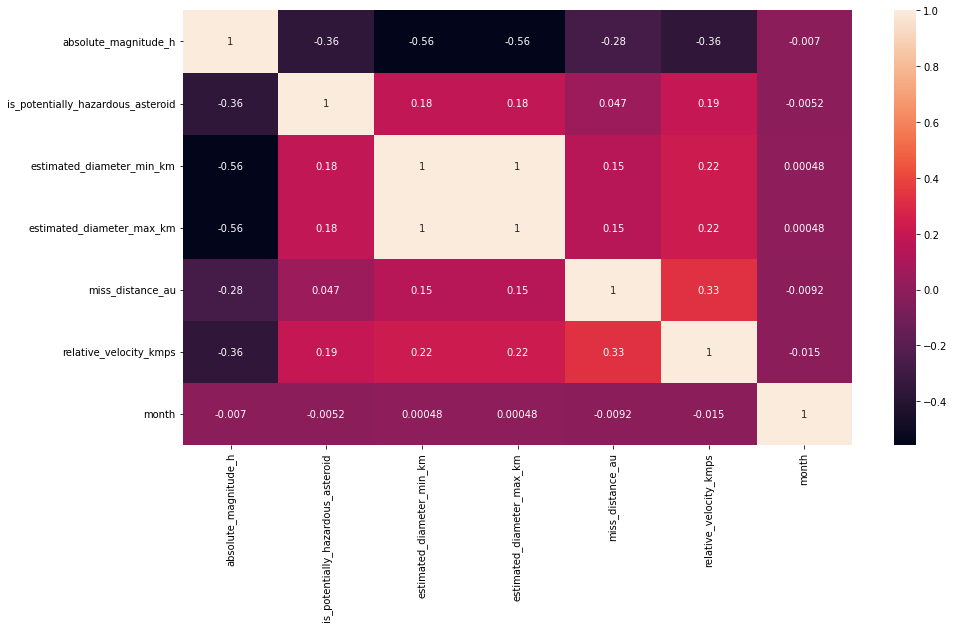

In [70]:
# correlation analysis
correlationanalysis = clean.corr()

# Importing our visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Resizing trick from matplotlib
plt.figure(figsize=(15,8))

# setting the annot argument to "True" to display labels
sns.heatmap(correlationanalysis,annot=True)

In [71]:
## including all previous columns, only dropping the dependent variable 'is_potentially_hazardous_asteroid'
##absolute_magnitude_h	estimated_diameter_min_km
##estimated_diameter_max_km	miss_distance_au	relative_velocity_kmps	month
X = clean[[
    'absolute_magnitude_h', 'estimated_diameter_min_km',
    'estimated_diameter_max_km', 'miss_distance_au', 'relative_velocity_kmps',
    'month'
]]
## Dep variable
# ensuring our y (prediction) is only included
y = clean['is_potentially_hazardous_asteroid']

In [77]:
#Creating Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

#Creating validation set
X_train, X2, y_train, y2 = train_test_split(X, y, test_size=0.2, random_state=30)

X_val, X_test, y_val, y_test = train_test_split(X2, y2, test_size=0.5, random_state=30)

# **Logistic Regression Model**

In [78]:
# initializing our logistic regression model, we set the maximum iterations to 3000 so that the model can find a solution. The default may be sufficient in most cases (100)
lr = LogisticRegression(random_state=7007, max_iter=3000)
lr.fit(X_train, y_train)

# using our model to predict
y_pred = lr.predict(X_test)

# evaluation
print("Accuracy Score:",accuracy_score(y_test, y_pred))

Accuracy Score: 0.8956575682382134


In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.99      0.94      7229
        True       0.45      0.05      0.09       831

    accuracy                           0.90      8060
   macro avg       0.67      0.52      0.52      8060
weighted avg       0.85      0.90      0.86      8060



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

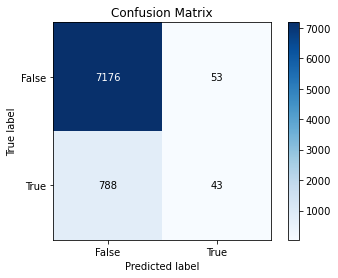

In [80]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

In [81]:
#Validation Set testing
lr = LogisticRegression(random_state=7007, max_iter=3000)
lr.fit(X_train, y_train)

# using our model to predict
y_pred = lr.predict(X_val)

# evaluation
print("Accuracy Score:",accuracy_score(y_val, y_pred))

Accuracy Score: 0.8993671671423253


# **Decesion Tree**

In [82]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy Score:",accuracy_score(y_test, y_pred))


Accuracy Score: 0.882258064516129


## **SVM Model**

In [84]:
svm = SVC()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print("Accuracy Score : ", accuracy_score(y_test,y_pred))

Accuracy Score :  0.8968982630272953


In [85]:
#Validation
svm = SVC()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_val)
print("Accuracy Score : ", accuracy_score(y_val,y_pred))

Accuracy Score :  0.898002233527733


# **Model 4: kNN**

In [86]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy Score : ", accuracy_score(y_test,y_pred))

Accuracy Score :  0.8803970223325062


# **Model 5: random forest**

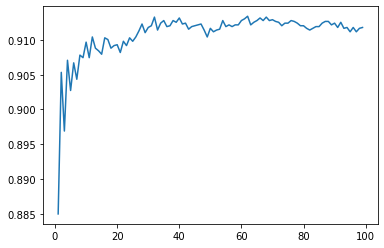

In [87]:
# the range of trees we want to test
numberoftrees = range(1, 100)
scores = []

# for loop
for n in numberoftrees:
    # in the n_estimators parameter, we're going to be testing all the values found in our range
    rf = RandomForestClassifier(n_estimators=n, random_state=1337)
    # fitting our model
    rf.fit(X_train, y_train)
    #prediction
    y_pred = rf.predict(X_test)
    # appending our result to variable scores
    scores.append(accuracy_score(y_test, y_pred))

# plotting our results
plt.plot(numberoftrees, scores)

In [88]:
# initializing our random forest model
rf = RandomForestClassifier(n_estimators=30)
rf.fit(X_train, y_train)

# using our model to predict
y_pred = rf.predict(X_test)

# accuracy score
accuracy_score(y_test, y_pred)

0.9122828784119107

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.93      0.98      0.95      7229
        True       0.64      0.34      0.44       831

    accuracy                           0.91      8060
   macro avg       0.79      0.66      0.70      8060
weighted avg       0.90      0.91      0.90      8060



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

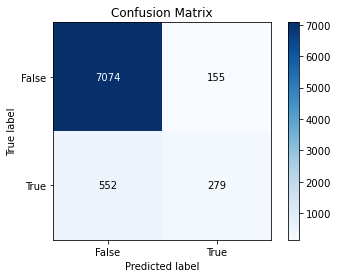

In [90]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

In [91]:
rf = RandomForestClassifier(n_estimators=30, random_state=110)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(accuracy_score(y_val, y_pred))

0.9147536915250031


<AxesSubplot:title={'center':'Feature Importance'}>

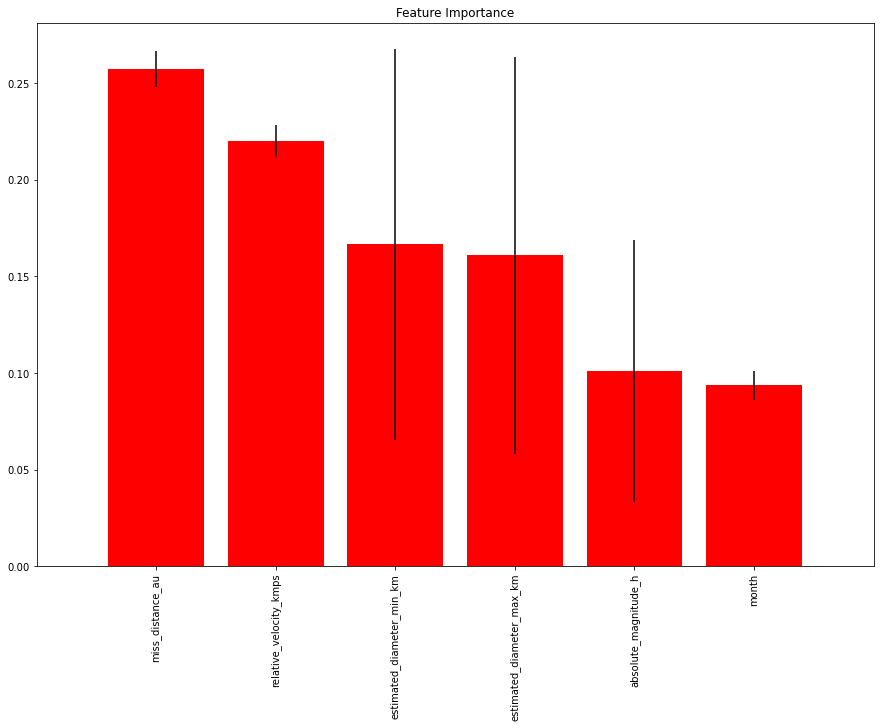

In [92]:
# assigning column names to variable 'feature_names'
feature_names = X.columns

skplt.estimators.plot_feature_importances(rf, feature_names=feature_names, figsize=(15, 10), x_tick_rotation=90)

# **Code Above**
---
